
# **COGNITION AND COMPUTATION**

---






# **Introduction**
In this project, we explore computational models of visual concept learning. The main objective of the project is to investigate the ability of the model to learn and represent visual concepts. The project is based on the Python code presented during the Lab practices. We use the FashionMNIST dataset for training and testing the model. In addition, we perform different analyses to explore the behavior of the model and its internal representations. 

we will use a Deep belief network(DBN) once with fine-tuning and once without fine-tuning, and then compare the results with the CNN and FNN models. Deep Belief Networks (DBNs) and Convolutional Neural Networks (CNNs) are both powerful models used in machine learning for various tasks including image classification, object detection, and data denoising.

DBNs are a class of neural networks that use multiple layers of hidden units to learn hierarchical representations of the input data. Each layer is trained to model the probability distribution of its inputs given the outputs of the previous layer. DBNs are good at learning complex representations of the data, and can be used for both supervised and unsupervised learning tasks. They have been successfully applied to a wide range of applications, such as speech recognition, image classification, and natural language processing.

CNNs, on the other hand, are a class of neural networks designed specifically for processing images. They are composed of several layers that perform feature extraction and transformation of the input image. The first layers typically perform simple local operations like edge detection, while the later layers learn more abstract features. CNNs have been shown to perform well on image classification tasks, and have been applied in various domains such as medical imaging and object detection.

# **The goals and reasons**  
First, we aim to investigate the strengths and weaknesses of two different types of models based on different learning methods - unsupervised and supervised learning. Second, we seek to assess the resilience of these models to different levels of noise in the input data, even in exchange of accuracy on not noisy images. Ultimately, we aim to identify a model that strikes a balance between complexity and resilience, such that it is able to perform well on noisy data while also being reasonably accurate on non-noisy data with less complexity at the same time.

In [2]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [3]:
%%capture
get_dbn_library()

In [4]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from sklearn.utils import shuffle
from random import randint
import matplotlib.pyplot as plt
import math
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import torchvision.transforms as transforms
import seaborn as sns; sns.set()
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from DBN import DBN



```
`# This is formatted as code`
```



In [11]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

False


# **DataSet**
The dataset used in this project is Fashion EMNIST, which comprises 60000 training images and 10000 test images. In order to increase the diversity of the images in the dataset, various augmentation methods have been applied. Additionally, to facilitate the training process, all images have been rescaled to a range of 0 to 1 by dividing the pixel values by 255. This preprocessing step is important for several reasons: it ensures that all images are on the same scale, which makes them easier to compare and analyze, and it also helps to avoid numerical instability issues that can arise during training when working with large pixel values. Overall, these preprocessing steps help to ensure that the dataset is well-suited for training a deep learning model.

In [6]:
%%capture
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# define a transform to convert the data to PyTorch tensors and normalize the pixel values
# define data augmentation transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



# load the training and testing sets
emnist_train = tv.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
emnist_test = tv.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



In [7]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

In [127]:
emnist_train.data.shape

torch.Size([60000, 28, 28])

# **FISRT MODEL (DBN)**
DBN stands for Deep Belief Network, which is a type of artificial neural network (ANN) composed of multiple layers of Restricted Boltzmann Machines (RBMs). RBMs are generative stochastic artificial neural network models that can learn a probability distribution over its set of inputs.

Here is an overview of the DBN and RBM architectures:

Restricted Boltzmann Machine (RBM)
An RBM consists of two layers of neurons: the visible layer and the hidden layer. The visible layer is connected to the hidden layer through undirected connections, and there are no connections between the neurons in the same layer. Each neuron in the visible layer corresponds to an input feature, while each neuron in the hidden layer corresponds to a latent feature that captures some higher-level representation of the inputs.

The RBM model has an energy-based formulation. The energy of the RBM is defined by the weights of the connections between the visible and hidden layers, as well as the biases of the neurons in both layers. The probability distribution of the input data can be learned by minimizing the energy of the RBM.

Deep Belief Network (DBN)
A DBN is composed of multiple layers of RBMs, where the hidden layer of each RBM is connected to the visible layer of the next RBM. The DBN architecture allows for the creation of a deep hierarchical representation of the inputs, where the lower-level layers capture simple features and the higher-level layers capture more complex features. The DBN model can be trained in a greedy layer-wise fashion, where each RBM is trained independently before being stacked to form the DBN.

#### **MODEL ARCHITECTURE**

After experimenting with various hyperparameter values, the architecture for my model was finalized with the following parameters. These values were chosen based on their performance in training:


*   The visible layer has 28x28 = 784 units (corresponding to the pixels in the images).

*   There are three hidden layers, each with 1000 units.
*   The contrastive divergence (CD) learning algorithm is used with k=1 (i.e., a single Gibbs sampling step is used for the approximation of the negative phase).
*   The learning rate is 0.01 and does not decay during training.
*   The initial momentum is 0.5 and is increased linearly to 0.95 over the course of training.
*   L2 weight decay regularization with coefficient 0.0001 is used.
*   The weights are initialized randomly.

In [8]:
dbn_mnist = DBN(visible_units=28*28,
                hidden_units=[1000, 1000, 2000],
                k=1,
                learning_rate=0.01,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

# New Section

In [96]:
num_epochs = 70
batch_size = 90

dbn_mnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.1786     |0.0963       |134.5316   |4.1630     |
|20    |1.8398     |0.0826       |113.4627   |3.0037     |
|30    |1.7353     |0.0798       |100.5181   |2.5444     |
|40    |1.6823     |0.0775       |93.9364   |2.1159     |
|50    |1.6480     |0.0771       |90.5808   |1.9276     |
|60    |1.6261     |0.0753       |87.8831   |2.0750     |
|70    |1.6077     |0.0739       |86.7290   |1.8378     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8932     |0.0327       |90.9118   |1.9117     |
|20    |0.7280     |0.0256       |79.3249   |1.5057     |
|30    |0.6844     |0.0243       |75.6426   |1.5768     |
|40    |0.6660     |0.0234       |73.5340   |1.5537     |
|50    |0.6556     |0.0235       |72.6753   |1.3906     |
|60    |0.6488     |0.0234       |71.5987   |1.2819     |
|70    |0.6454     |0.0240       |71.3526  

## **Analyzing the internal representation developed by the model using hierarchical clustering and feature visualization methods**

#**Feature visualization function:**

The code represents a function called "feature_visualization" that takes a DBN model, number of layers, and a threshold as input arguments. This function aims to visualize the learned features of the given DBN model.

* The first helper function "get_weights" retrieves the weights of a particular layer from the DBN model. 
* The second helper function "apply_threshold" applies a threshold value to the given weights matrix and returns the thresholded weights. * The third helper function "plot_layer_receptive_fields" visualizes the receptive fields of a layer by plotting the weights as images. 
* The fourth helper function "apply_min_max_scaler" scales the given weights matrix to the range of [0,1] using the MinMaxScaler from the sklearn.preprocessing module.

The main functionality of the "feature_visualization" function is to iterate through each layer of the DBN model and retrieve the weights of each layer. Then, the function applies a threshold to the weights matrix of each layer and takes the dot product of all the learned weights matrices up to the current layer. The final weights matrix is then scaled using the MinMaxScaler and visualized as receptive fields using the "plot_layer_receptive_fields" function.

In summary, the "feature_visualization" function visualizes the learned features of the given DBN model using a combination of thresholding and MinMax scaling techniques to make the visualization more interpretable.






In [10]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights 

def feature_visualization(dbn_model, num_layer, threshold):
  learned_weights_layers = []
  learned_weights_product = np.eye(len(get_weights(dbn_model, layer=0)))
  
  for i in range(num_layer+1):
    learned_weights_layers.append(get_weights(dbn_model, layer=i))
    learned_weights_layers[i] = apply_threshold(learned_weights_layers[i], threshold)
    learned_weights_product = learned_weights_product@learned_weights_layers[i]

  if(num_layer>0):
    learned_weights_product = apply_threshold(learned_weights_product, threshold)
  learned_weights_product = apply_min_max_scaler(learned_weights_product)
  plot_layer_receptive_fields(learned_weights_product.T) 
  

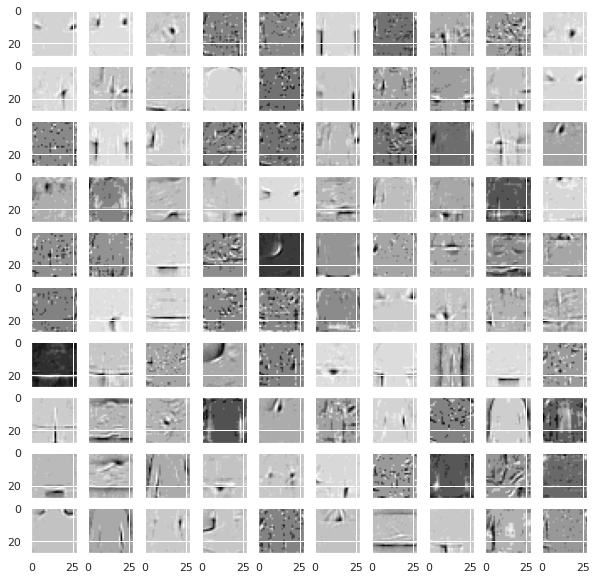

In [97]:
feature_visualization(dbn_mnist, num_layer=0, threshold= 0.1)


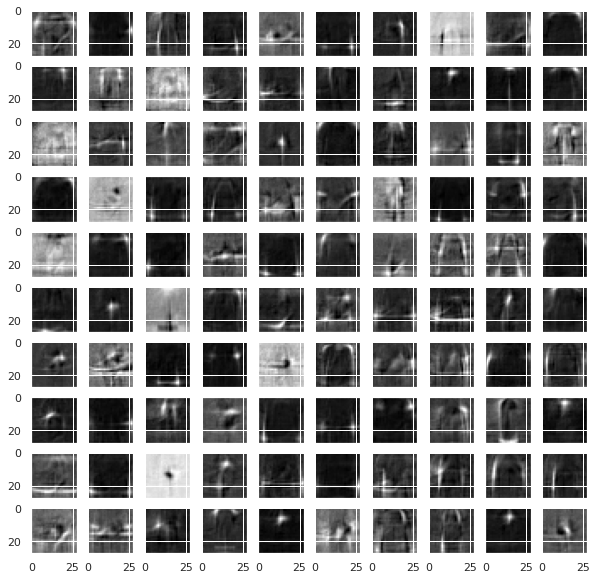

In [98]:
feature_visualization(dbn_mnist, num_layer=1, threshold= 0.1)


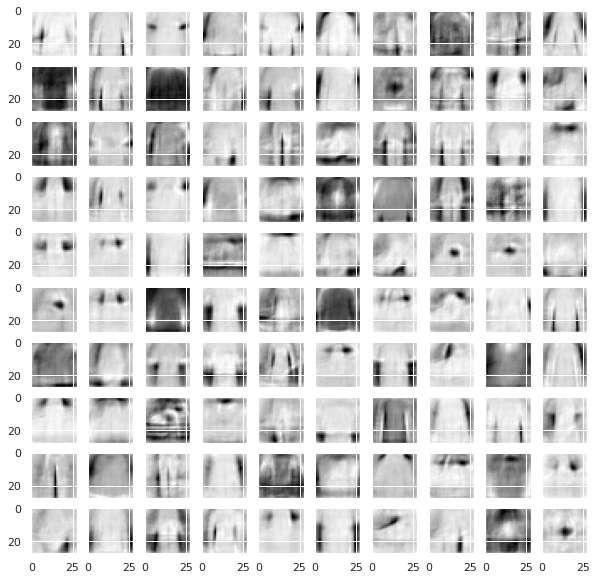

In [102]:
feature_visualization(dbn_mnist, num_layer=2, threshold= 0.1)

#**hierarchical clustering function**

This code defines several functions for hierarchical clustering based on the hidden representations of a DBN model trained on the FASHIONMNIST dataset.

* get_kth_layer_repr(input, k, device) takes an input tensor, the index k of the layer in the DBN, and the device (CPU or GPU) to perform the computations on. It returns the hidden representation of the input at the k-th layer.

* get_mask(label, dataset) takes a label and a dataset object and returns a boolean mask that is True for the examples in the dataset with the given label.

* get_label_to_mean_hidd_repr(hidden_representation, dataset) takes the hidden representation of the dataset computed by the DBN and the dataset object itself. It returns a dictionary that maps each label to the mean hidden representation of the examples in the dataset with that label.

* get_hidden_reprs_matrix(hidden_representation, dataset) takes the hidden representation of the dataset computed by the DBN and the dataset object itself. It uses get_label_to_mean_hidd_repr to compute the mean hidden representation of each label and concatenates them into a matrix.

* plot_dendrogram(mean_repr_matrix, title="") takes the matrix of mean hidden representations and a title for the plot. It performs hierarchical clustering on the mean hidden representations and plots a dendrogram.

In [115]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_mnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

def get_mask(label,dataset):  # we use this function to filter by class
  labels = dataset.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation,dataset):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label,dataset)].mean(axis=0)  # here we filter by class and compute the mean
    for label in set(emnist_train.targets.cpu().numpy())
  }

def get_hidden_reprs_matrix(hidden_representation,dataset):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation,dataset)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in set(emnist_train.targets.cpu().numpy())])
  
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  # Define class names
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  
  # Map class names to label numbers
  label_map = {class_name: i for i, class_name in enumerate(class_names)}
  labels = [label_map[class_name] for class_name in class_names]
    
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # run the clustering algorithm
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=labels, orientation='left')
    
  ax.set_title(title)
  ax.set_ylabel("Class Names")
  ax.set_xlabel("Distance")
  plt.show()


def make_hierarchy_func(input,num_layer,device,dataset):
  current_layer = input
  for i in range(num_layer):
    current_layer = get_kth_layer_repr(current_layer, i, device)
  mean_hidd_repr_matrix = get_hidden_reprs_matrix(current_layer,dataset)
  plot_dendrogram(mean_hidd_repr_matrix_3,i,"th hidden layer")




In [103]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [104]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3, emnist_train)

### **Hierarchical Clustering Plot**
The hierarchical clustering plot is a visualization of how the different classes in the Fashion EMNIST dataset are related to each other based on their feature representations learned by the DBN model. The plot shows how the classes are grouped together in a hierarchical structure, with some classes being more closely related to each other than others. This can provide insights into the similarities and differences between the classes and how the model is able to distinguish between them.

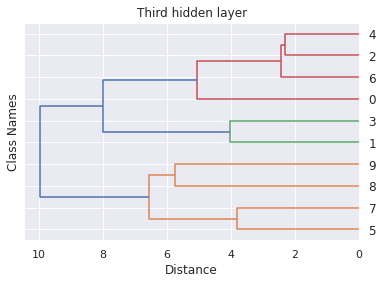

In [116]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

Linear read-out

In [9]:

class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    actfunc = torch.nn.LogSoftmax(dim=1)
    return actfunc(self.linear(x))

class LinearComplex(torch.nn.Module):
  def __init__(self, last_layer_size):
    super().__init__()
    self.linear1 = torch.nn.Linear(last_layer_size, 256)
    self.linear2 = torch.nn.Linear(256, 128)
    self.linear3 = torch.nn.Linear(128, 10)

  def forward(self, x):
    x = self.linear1(x)
    x = torch.nn.functional.relu(x)
    x = self.linear2(x)
    x = torch.nn.functional.relu(x)
    x = self.linear3(x)
    x = torch.nn.LogSoftmax(x)
    return x

def train_linear(linear, hidden_reprs,data_set = emnist_train):
  epochs = 1500
  print_stride = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.Adam(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = data_set.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % print_stride == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))
  return linear

def train_linear_layer(num_layer,dbn):
  layer_size = dbn_mnist.rbm_layers[num_layer].W.shape[1]
  linear = LinearModel(layer_size).to(device)
  hidden_repr_layer = get_kth_layer_repr(emnist_train.data, num_layer, device)
  linear = train_linear(linear, hidden_repr_layer)
  return linear


def compute_accuracy_layer(model, input, targets, num_layer):
  hidden_repr_layer = get_kth_layer_repr(input, num_layer, device)
  predictions_test = model(hidden_repr_layer )
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [107]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [108]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)
print('training for first layer')
layer_size = dbn_mnist.rbm_layers[0].W.shape[1]
linear_1 = LinearModel(layer_size).to(device)
train_linear(linear_1, hidden_repr_layer_1, emnist_train)
print('training for second layer')
layer_size = dbn_mnist.rbm_layers[1].W.shape[1]
linear_2 = LinearModel(layer_size).to(device)
train_linear(linear_2, hidden_repr_layer_2, emnist_train)
print('trainig for third layer')
layer_size = dbn_mnist.rbm_layers[2].W.shape[1]
linear_3 = LinearModel(layer_size).to(device)
train_linear(linear_3, hidden_repr_layer_3, emnist_train)

training for first layer
epoch :   1/1500, loss = 2.3250
epoch : 101/1500, loss = 0.2815
epoch : 201/1500, loss = 0.2518
epoch : 301/1500, loss = 0.2372
epoch : 401/1500, loss = 0.2395
epoch : 501/1500, loss = 0.2209
epoch : 601/1500, loss = 0.2158
epoch : 701/1500, loss = 0.2137
epoch : 801/1500, loss = 0.2089
epoch : 901/1500, loss = 0.2053
epoch : 1001/1500, loss = 0.2034
epoch : 1101/1500, loss = 0.2042
epoch : 1201/1500, loss = 0.2002
epoch : 1301/1500, loss = 0.1971
epoch : 1401/1500, loss = 0.1965
training for second layer
epoch :   1/1500, loss = 2.3394
epoch : 101/1500, loss = 0.3196
epoch : 201/1500, loss = 0.2860
epoch : 301/1500, loss = 0.2694
epoch : 401/1500, loss = 0.2584
epoch : 501/1500, loss = 0.2501
epoch : 601/1500, loss = 0.2436
epoch : 701/1500, loss = 0.2384
epoch : 801/1500, loss = 0.2355
epoch : 901/1500, loss = 0.2311
epoch : 1001/1500, loss = 0.2319
epoch : 1101/1500, loss = 0.2297
epoch : 1201/1500, loss = 0.2264
epoch : 1301/1500, loss = 0.2246
epoch : 1401

LinearModel(
  (linear): Linear(in_features=1000, out_features=10, bias=True)
)

In [109]:
hidden_repr_layer1 = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer2 = get_kth_layer_repr(hidden_repr_layer1, 1, device)
hidden_repr_layer3 = get_kth_layer_repr(hidden_repr_layer2, 2, device)

predictions_test1 = linear_1(hidden_repr_layer1)
predictions_test2 = linear_2(hidden_repr_layer2)
predictions_test3 = linear_3(hidden_repr_layer3)

In [110]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.885699987411499

In [111]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.8849999904632568

In [112]:
compute_accuracy(predictions_test3, emnist_test.targets)

0.8844999670982361

### **Confusion Matrix**
The confusion matrix is a tool for evaluating the performance of the DBN model on the Fashion EMNIST dataset. It shows how often the model correctly predicted each class and how often it made errors. The matrix can help identify which classes the model is having difficulty with and can be used to calculate various performance metrics such as accuracy, precision, and recall. By analyzing the confusion matrix, we can gain insights into how well the model is performing and how it could be improved.

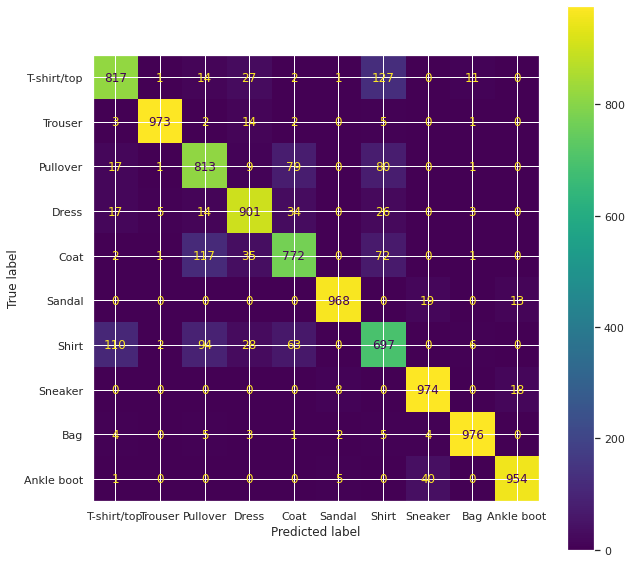

In [117]:
#confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_pred = np.array(predictions_test3.max(axis=1).indices.to("cpu"))
y_test = np.array(emnist_test.targets.to("cpu"))
# Define a list of names for the labels
labels= ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



cm = confusion_matrix(y_test, y_test_pred, labels=None)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)


fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

In [118]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(7 * 7 * 64, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 47)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 7 * 7 * 64)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


train_loader = torch.utils.data.DataLoader(tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [119]:

def trainCNN(data_loader,CNN_model):
    # initialize the CovNet model
    CNN_model = CNN_model

    # define the loss function
    criterion = nn.CrossEntropyLoss()

    # define the optimizer
    optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)

    # train the model for 10 epochs
    num_epochs = 60
    print_stride = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = CNN_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        if epoch % print_stride == 0:print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, num_epochs, loss))
          
  
    print('Finished Training')


    correct = 0
    total = 0

    with torch.no_grad():
            CNN_model.eval()
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = CNN_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    return correct/total
    


In [120]:
CNN_model = ConvNet().to(device)

In [121]:
accuracy = trainCNN(train_loader,CNN_model)
print(accuracy)

epoch :   1/60, loss = 0.3988
epoch :  11/60, loss = 0.0380
epoch :  21/60, loss = 0.0134
epoch :  31/60, loss = 0.0020
epoch :  41/60, loss = 0.0043
epoch :  51/60, loss = 0.0058
Finished Training
0.9982


In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(1000, 1000, 2000).to(device)

In [ ]:
train_linear(ffnn, mnist_train.data.reshape((60000, 784)), epochs=1500)

In [ ]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(num_features=32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64 * 250, out_features=128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# define the CNN model
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(4480, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 1, 1000)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 4480)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.softmax(self.fc2(x), dim=1)
        return x

# create the model and define the loss function and optimizer
model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# create a random input array of size [6000, 1000]
X = np.random.randn(6000, 1000)

# create a random target array of size [6000] with values between 0 and 9
y = np.random.randint(0, 10, 6000)

# convert the input and target arrays to PyTorch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

# train the model
num_epochs = 10
batch_size = 32
for epoch in range(num_epochs):
    for i in range(0, len(X), batch_size):
        inputs = X_tensor[i:i+batch_size]
        targets = y_tensor[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    # calculate accuracy after each epoch
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs.data, 1)
        total = y_tensor.size(0)
        correct = (predicted == y_tensor).sum().item()
        accuracy = 100 * correct / total
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch+1, num_epochs, loss.item(), accuracy))



## **Robustness to noise**

The Fast Gradient Sign Method (FGSM) is a popular technique for creating adversarial examples. It is a type of white-box attack, which means that the attacker has access to the model's architecture and parameters.

The basic idea behind FGSM is to take the gradient of the loss function with respect to the input, and then perturb the input in the direction of the sign of the gradient. The amount of perturbation is controlled by a hyperparameter ε, which is usually set to a small value.

The formula for FGSM can be expressed as:

𝑥̃ =𝑥+𝜖⋅sign(∇𝑥𝐽(𝑤,𝑥,𝑦))

where 𝑥 is the original input, 𝑥̃ is the perturbed input, 𝜖 is the size of the perturbation, ∇𝑥𝐽(𝑤,𝑥,𝑦) is the gradient of the loss function with respect to the input, and sign(∇𝑥𝐽(𝑤,𝑥,𝑦)) is the sign of the gradient.

By adding the sign of the gradient multiplied by a small value ε to the input, the FGSM algorithm can create adversarial examples that fool the model. These examples are similar to the original inputs, but have been perturbed in a way that the model misclassifies them.

FGSM is a powerful technique that can be used to test the robustness of machine learning models, as well as to create attacks on these models. However, it is important to note that there are other more sophisticated attacks that can be used against models, and that models can be made more robust against attacks by using techniques such as adversarial training.

In [77]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False,download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [78]:
from tqdm.notebook import tqdm
import torch.nn.functional as functional

In [79]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

def get_accuracy_values_at_noise_level(noise_level,num_layer):
  acc = []
  for noise in noise_level:
    mnist_test_with_noise = inject_noise(emnist_test.data, noise)
    model = train_linear_layer(num_layer, dbn_mnist)
    acc.append(compute_accuracy_layer(model, mnist_test_with_noise, emnist_test.targets))
  return acc


noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

def plot_noise_robustness_curves(noise_levels,num_layer):
  acc_mat = []
  fig, ax = plt.subplots()
  for i in range(num_layer):
    acc_mat.append(get_accuracy_values_at_noise_level(noise_levels,num_layer))
    ax.plot(range(len(noise_levels)),  acc_mat[i])


  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])


Perturbing the models with adversarial attacks

In [80]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [81]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [82]:
dbn_with_readout = DBNWithReadOut(dbn_mnist, [linear_1, linear_2, linear_3], readout_level=2)

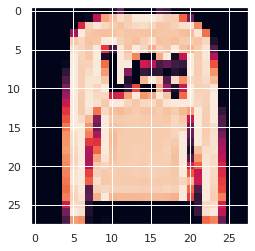

In [83]:
test_sample_idx = 1
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

In [84]:
attacked_model = dbn_with_readout

In [85]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 2.


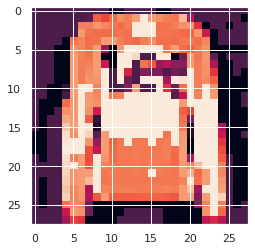

In [86]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [87]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 6.


In [88]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        if model != CNN_model: data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [89]:

final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 27.40%



In [90]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [91]:
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0
Test Accuracy: 88.34%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.05
Test Accuracy: 54.58%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 27.40%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.15
Test Accuracy: 15.28%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 8.67%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.25
Test Accuracy: 5.90%



In [92]:
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)


  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0
Test Accuracy: 86.25%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.05
Test Accuracy: 73.23%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 40.38%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.15
Test Accuracy: 21.68%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 13.74%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.25
Test Accuracy: 9.36%



In [93]:
accuracies_CNN = test_epsilon_values_effect(CNN_model, n_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0
Test Accuracy: 100.00%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.05
Test Accuracy: 36.08%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 7.85%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.15
Test Accuracy: 1.56%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 0.34%



  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.25
Test Accuracy: 0.10%



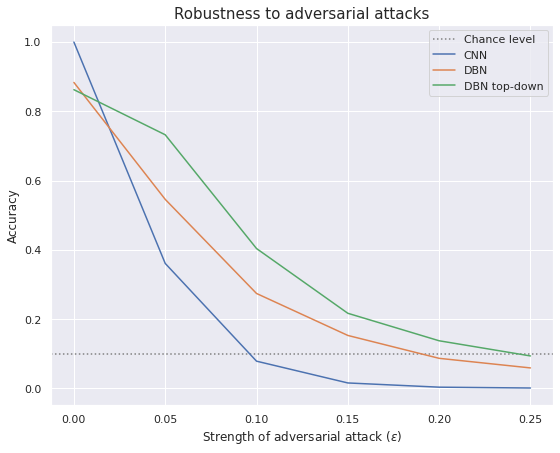

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_CNN)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level","CNN","DBN", "DBN top-down"])